# Math 607 Applied Math I: Week 3 Homework

Due date: Thursday, Oct 21.

Please submit your solutions by upload on Canvas.

It's absolutely OK if you work together on these problems - and this is especially true for the programming problems, when encourage you to work in pairs at one computer, with one person typing and one person thinking.

We do want everyone to write up each assignment on their own.

# 1. $d$-regular eigenvalues

Recall that the *adjacency matrix* $A$ of an undirected graph is the matrix with $A_{ij} = 1$ if there is an edge between $i$ and $j$ in the graph, and $A_{ij} = 0$ otherwise.
A $d$*-regular* graph is one for which the degree of every vertex is exactly $d$.

*a.* Show that the adjacency matrix of the *complete graph* on $n$ vertices (i.e., the $(n-1)$-regular graph)
    has two eigenvalues: $n-1$, with multiplicity 1, and $-1$, with multiplicity $n-1$.
    
*b.* Show that the adjacency matrix of any $d$-regular graph has an eigenspace with eigenvalue $d$. What determines the dimension of this eigenspace?

<img src="https://github.com/mufernando/math607/blob/main/hw/img/hw4_1.jpeg?raw=true" width=400 />

# 2. Uniform spanning trees

One way to sample a uniform spanning tree of a graph $G$
is the *Aldous-Broder* algorithm: choose a vertex $r$ of $G$ and perform a random walk on $G$, starting at $r$,
until every vertex has been visited.
For each vertex $w \neq r$, remember the edge that was traversed by
the walk on it's first visit to $w$.
These edges are the uniform spanning tree.
(For simplicity, we're dealing with an unweighted graph -
all weights are 1 - and the "random walk on a graph"
is the one that, at each time step, chooses a random edge
incident to the vertex it's currently at
to move along.)

**(a)** Implement the Aldous-Broder algorithm on the $m \times n$ grid.

**(b)** Plot an example or two on a 30x40 grid.
(It may be helpful to look at the plotting code [here](https://uo-applied-math.github.io/applied_math/2019/demos/random_spanning_tree.html).

**(c)** How many spanning trees *are* there of the 30x40 grid?

In [1]:
import numpy as np
rng = np.random.default_rng(seed=31)

In [2]:
def possible_steps(node, m, n):
    # finds the allowed steps from node in a mxn grid
    steps = np.array([[0,1],[0,-1],[-1,0],[1,0]])
    possibilities = node + steps
    #print(possibilities[:,1] >= n)
    allowed = ((possibilities[:,0] >= m) + 
                   (possibilities[:,0] < 0) + 
                   (possibilities[:,1] >= n) + 
                   (possibilities[:,1] < 0)) == 0
    return steps[allowed]

In [3]:
def aldous_broder_grid(m,n):
    all_nodes = [(i, j) for i in range(m) for j in range(n)]
    start = tuple(rng.choice(all_nodes))
    xy = np.array([[(0,0) for _ in range(n)] for _ in range(m)])
    tree = [start]
    current = start
    while set(tree) != set(all_nodes):
        #print("old: ", current)
        steps = possible_steps(current,m,n)
        step = rng.choice(steps)
        current = tuple(current+step)
        #print("new: ",current)
        if current not in tree:
            tree.append(current)
            xy[current] = -step
            #print("forward step: ", step)
            #print("back step: ", -step)
    return tree, xy

In [4]:
m = 30
n = 40
tree, xy = aldous_broder_grid(m,n)

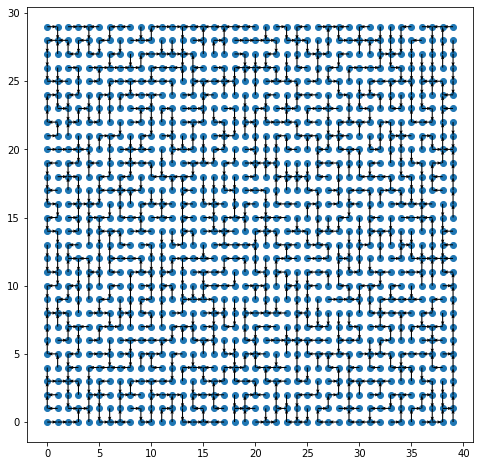

In [5]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

points = np.array([[i, j] for i in range(m) for j in range(n)])

fig, ax = plt.subplots()
ax.scatter(points[:, 1], points[:, 0])
ax.quiver(np.arange(n), np.arange(m),
          xy[:,:,1], xy[:,:,0], scale_units='xy', angles='xy', scale=1)

In [6]:
def gen_adj_grid(m,n):
    # generates adjacency matrix for mxn grid
    nodes = [(x,y) for x in range(m) for y in range(n)]
    # mapping nodes to integers (rows and cols in Adj mat)
    nodes_map = {node: i for i, node in enumerate(nodes)}
    A = np.zeros((m*n,m*n))
    for node, i in nodes_map.items():
        steps = possible_steps(node,m,n)
        for step in steps:
            A[i,nodes_map[tuple(node+step)]] = 1
    return(A, nodes_map)

In [7]:
def graph_laplacian(A):
    # computes the graph laplacian as defined in class
    L = np.empty(shape=A.shape)
    for i in range(len(A)):
        for j in range(len(A)):
            if A[i,j] == 1:
                L[i,j] = -1
            if (i != j) and (A[i,j] == 0):
                L[i,j] = 0
            if i == j:
                L[i,j] = np.sum(A[i,:])
                    
    return L

def graph_laplacian2(A):
    #alternative impl (from wikipedia)
    return (np.diag(np.sum(A,axis=1)) - A)

In [8]:
A, nodes_map = gen_adj_grid(30,40)

In [9]:
L = graph_laplacian(A)

In [10]:
# making sure that rows sum to 0!
assert (np.sum(L, axis=1) == 0).all()

In [11]:
L2 = graph_laplacian2(A)

In [12]:
assert (L == L2).all()

In class, we proved the Matrix Tree Theorem, which states that the number of possible spanning trees in a graph is the determinant of the laplacian matrix (minus any chosen row and column). Note below it seeems there are so many possible spanning trees on a 30x40 grid (the natural log of 1336).

In [13]:
np.linalg.slogdet(L[:-1,:-1])

(1.0, 1336.6126939570163)

Also note that it really doesn't matter which row and column you remove!

In [14]:
Lv = L
Lv = np.delete(L, 2, axis = 1)
Lv = np.delete(L, 34, axis = 0)
np.linalg.slogdet(L[:-1,:-1])

(1.0, 1336.6126939570163)

# 3. The Ising model

Use the Metropolis-Hastings algorithm to sample from the Ising model's
distribution, and plot the results on a 100x100 grid at $T=0.01$.
Explain carefully why your algorithm works.
Here is some skeleton code to do this:

In [15]:
class Ising(object):
    
    def __init__(self, n, m):
        self.n = n
        self.m = m
        self.state = np.random.choice([-1, 1], n*m).reshape((n, m))

    def flip_spin(self, node):
        self.state[node] = -1*self.state[node]

    def H(self, node):
        # only getting the H for the neighbors of the node!!
        steps = possible_steps(node, self.n, self.m)
        neighbors = node + steps
        s = 0
        for nei in neighbors:
            s += self.state[node] * self.state[tuple(nei)]
        return -s

    def plot(self):
        fig, ax = plt.subplots()
        ax.set_aspect(1)
        xy = np.array([[a, b] for a in range(self.n) for b in range(self.m)])
        fills = ['black' if (s == 1) else 'white' for s in self.state.reshape((self.n*self.m,))]
        ax.scatter(xy[:,0], xy[:,1], c=fills, marker="8", s=5)
    
    def update(self, T):
        # first, we must pick a node (our proposal dist will be uniform on the grid)
        node = (rng.integers(0,self.n), rng.integers(0,self.m))
        # Let's compute the Hamiltonian func for that node 
        Hc = self.H(node)
        # Now let's flip the spin of that node
        self.flip_spin(node)
        # Compute Hamiltonian for the proposed change
        Hp = self.H(node)
        # Now we will want to keep the proposal with prob:
        # (note that)
        prob = np.min([np.exp(-(Hp-Hc)/T),1])
        # just draw a random number in [0,1) and we 
        # will undo the flip if the draw is greater than our
        # prob.
        p = rng.uniform()
        if p > prob:
            self.flip_spin(node)

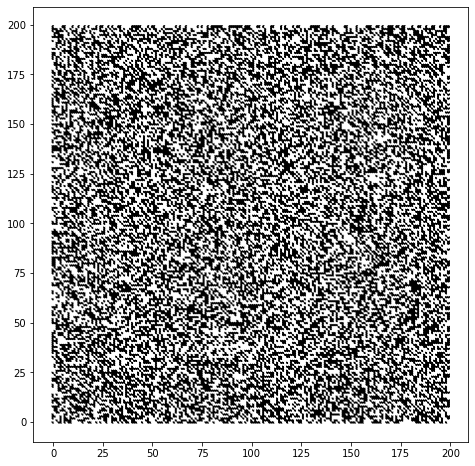

In [16]:
ising = Ising(200, 200)
ising.plot()

/opt/anaconda3/envs/math-py/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


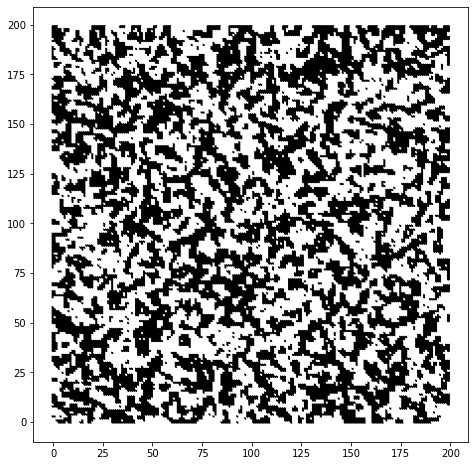

In [17]:
for _ in range(100000):
    ising.update(0.01)
ising.plot()

# 4. Random walk on a graph

Let $X$ be the random walk on an unweighted graph $G = (V,E)$,
i.e., the transition probabilities are
$\mathbb{P}\{X_{k+1} = y \;\|\; X_k=x\} = 1/\text{deg}(x)$
for $(x,y) \in E$ and 0 otherwise.


**(a)** Show that $X$ is reversible with respect to
$$ \pi(x) \propto \text{deg}(x) .$$

**(b)** Let $A$ be the adjacency matrix of the graph
and $D$ be the diagonal matrix with $D_{xx} = \text{deg}(x)$.

Show that $P = D^{-1} A$ is the transition matrix for $X$, so
$$
  \mathbb{E}[f(X_t) \;|\; X_0 = x] = (P^t f)(x) .
$$

**(c)** How could we minimally modify the random walk
so that the stationary distribution was *uniform*?

<img src="https://github.com/mufernando/math607/blob/main/hw/img/hw4_4a.jpeg?raw=true" width=400 />

<img src="https://github.com/mufernando/math607/blob/main/hw/img/hw4_4bc.jpeg?raw=true" width=400 />